In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
pyo.init_notebook_mode(connected=True)

print("✅ All libraries imported successfully!")
print("📊 Ready to build Kenya Food Security Warning System")


✅ All libraries imported successfully!
📊 Ready to build Kenya Food Security Warning System


In [59]:
df = pd.read_csv('kenya_food_security_data.csv')

print("🔍 DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Counties covered: {df['county'].unique()}")

# Basic info
print("\n📋 COLUMN INFORMATION")
print("=" * 50)
print(df.info())

print("\n📊 STATISTICAL SUMMARY")
print("=" * 50)
print(df.describe())

# Check for missing values
print("\n❌ MISSING VALUES")
print("=" * 50)
print(df.isnull().sum())

# Display first few rows
print("\n👀 FIRST 5 ROWS")
print("=" * 50)
print(df.head())

🔍 DATASET OVERVIEW
Dataset shape: (24, 19)
Date range: 2023-01-01 to 2024-12-01
Counties covered: ['Turkana']

📋 COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 24 non-null     object 
 1   county               24 non-null     object 
 2   population           24 non-null     int64  
 3   rainfall_mm          24 non-null     int64  
 4   rainfall_anomaly     24 non-null     float64
 5   temperature_avg      24 non-null     float64
 6   food_price_index     24 non-null     int64  
 7   maize_price_ksh      24 non-null     int64  
 8   beans_price_ksh      24 non-null     int64  
 9   ipc_phase            24 non-null     int64  
 10  ipc_population       24 non-null     int64  
 11  conflict_events      24 non-null     int64  
 12  conflict_fatalities  24 non-null     int64  
 13  ndvi_anoma

In [47]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

# Create lag features (previous month values)
df = df.sort_values('date')
df['rainfall_lag1'] = df['rainfall_mm'].shift(1)
df['food_price_lag1'] = df['food_price_index'].shift(1)
df['conflict_lag1'] = df['conflict_events'].shift(1)

# Create moving averages
df['rainfall_ma3'] = df['rainfall_mm'].rolling(window=3).mean()
df['food_price_ma3'] = df['food_price_index'].rolling(window=3).mean()

# Create risk indicators
df['drought_risk'] = np.where(df['rainfall_anomaly'] < -30, 1, 0)
df['price_shock'] = np.where(df['food_price_index'] > 100, 1, 0)
df['conflict_risk'] = np.where(df['conflict_events'] > 2, 1, 0)

# Combined risk score
df['combined_risk_score'] = (
    df['drought_risk'] * 0.4 +
    df['price_shock'] * 0.3 +
    df['conflict_risk'] * 0.3
) * 100

# Create target variable for next month IPC phase
df['next_month_ipc'] = df['ipc_phase'].shift(-1)
df['ipc_deterioration'] = np.where(df['next_month_ipc'] > df['ipc_phase'], 1, 0)

print("✅ Feature engineering completed!")
print(f"New dataset shape: {df.shape}")
print(f"New features created: {df.columns[-10:].tolist()}")

✅ Feature engineering completed!
New dataset shape: (24, 33)
New features created: ['food_price_lag1', 'conflict_lag1', 'rainfall_ma3', 'food_price_ma3', 'drought_risk', 'price_shock', 'conflict_risk', 'combined_risk_score', 'next_month_ipc', 'ipc_deterioration']


In [48]:
# Create comprehensive time series visualization
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=('IPC Phase Evolution', 'Rainfall Patterns', 'Food Price Trends', 'Conflict Events'),
    vertical_spacing=0.08,
    specs=[[{"secondary_y": False}],
           [{"secondary_y": True}],
           [{"secondary_y": False}],
           [{"secondary_y": True}]]
)

# IPC Phase
fig.add_trace(
    go.Scatter(x=df['date'], y=df['ipc_phase'], mode='lines+markers',
               name='IPC Phase', line=dict(color='red', width=3)),
    row=1, col=1
)

# Rainfall with anomaly
fig.add_trace(
    go.Scatter(x=df['date'], y=df['rainfall_mm'], mode='lines',
               name='Rainfall (mm)', line=dict(color='blue')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df['date'], y=df['rainfall_anomaly'], mode='lines',
               name='Rainfall Anomaly (%)', line=dict(color='orange')),
    row=2, col=1, secondary_y=True
)

# Food prices
fig.add_trace(
    go.Scatter(x=df['date'], y=df['food_price_index'], mode='lines',
               name='Food Price Index', line=dict(color='green')),
    row=3, col=1
)

# Conflict events with fatalities
fig.add_trace(
    go.Bar(x=df['date'], y=df['conflict_events'], name='Conflict Events',
           marker_color='darkred', opacity=0.7),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df['date'], y=df['conflict_fatalities'], mode='lines',
               name='Fatalities', line=dict(color='black')),
    row=4, col=1, secondary_y=True
)

fig.update_layout(
    title_text="Kenya Food Security Indicators - Turkana County",
    height=800,
    title_x=0.5,
    showlegend=True
)

fig.show()

print("📈 Time series visualization completed!")

📈 Time series visualization completed!


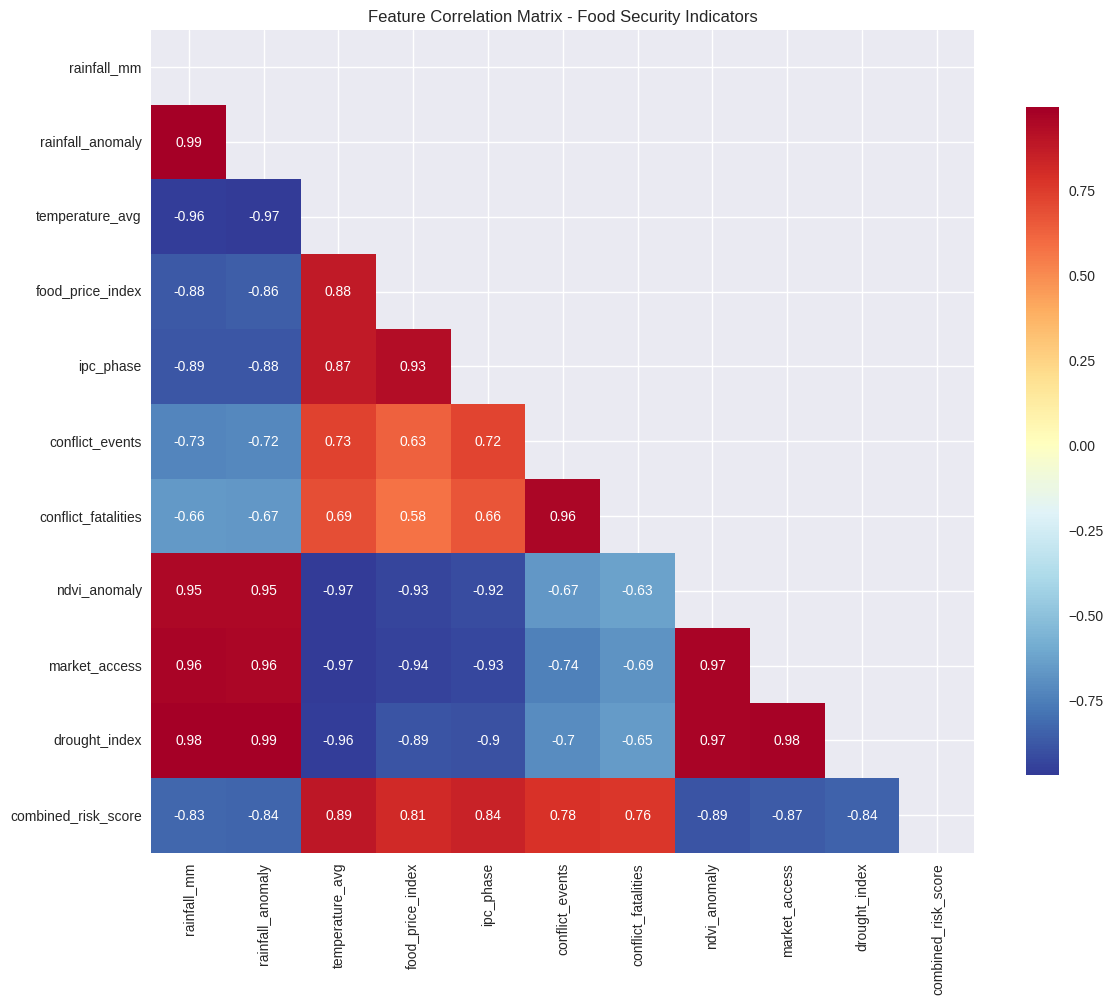


🎯 KEY CORRELATIONS WITH IPC PHASE
food_price_index          ↗️ 0.929
market_access             ↘️ -0.926
ndvi_anomaly              ↘️ -0.917
drought_index             ↘️ -0.899
rainfall_mm               ↘️ -0.886
rainfall_anomaly          ↘️ -0.878
temperature_avg           ↗️ 0.870
combined_risk_score       ↗️ 0.839
conflict_events           ↗️ 0.716
conflict_fatalities       ↗️ 0.663


In [49]:
# Select numeric columns for correlation analysis
numeric_cols = ['rainfall_mm', 'rainfall_anomaly', 'temperature_avg', 'food_price_index',
                'ipc_phase', 'conflict_events', 'conflict_fatalities', 'ndvi_anomaly',
                'market_access', 'drought_index', 'combined_risk_score']

correlation_matrix = df[numeric_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
            center=0, square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix - Food Security Indicators')
plt.tight_layout()
plt.show()

# Key correlations with IPC phase
ipc_correlations = correlation_matrix['ipc_phase'].sort_values(key=abs, ascending=False)
print("\n🎯 KEY CORRELATIONS WITH IPC PHASE")
print("=" * 50)
for feature, corr in ipc_correlations.items():
    if feature != 'ipc_phase':
        direction = "↗️" if corr > 0 else "↘️"
        print(f"{feature:<25} {direction} {corr:.3f}")

🌦️ SEASONAL PATTERNS
                   rainfall_mm  food_price_index  ipc_phase  conflict_events
season      month                                                           
Dry         1             43.5              88.5        2.5                3
            2             35.0              93.0        3.0                3
            6             26.5              98.0        3.0                4
            7             19.0             104.5        4.0                7
            8             15.5             109.0        4.0                5
            12            66.5              87.0        2.0                1
Long_Rains  3             29.0              97.5        3.0                4
            4             61.5              89.5        2.0                1
            5             75.0              83.5        2.0                1
Short_Rains 9             23.0             107.0        4.0                3
            10            36.5             101.0       

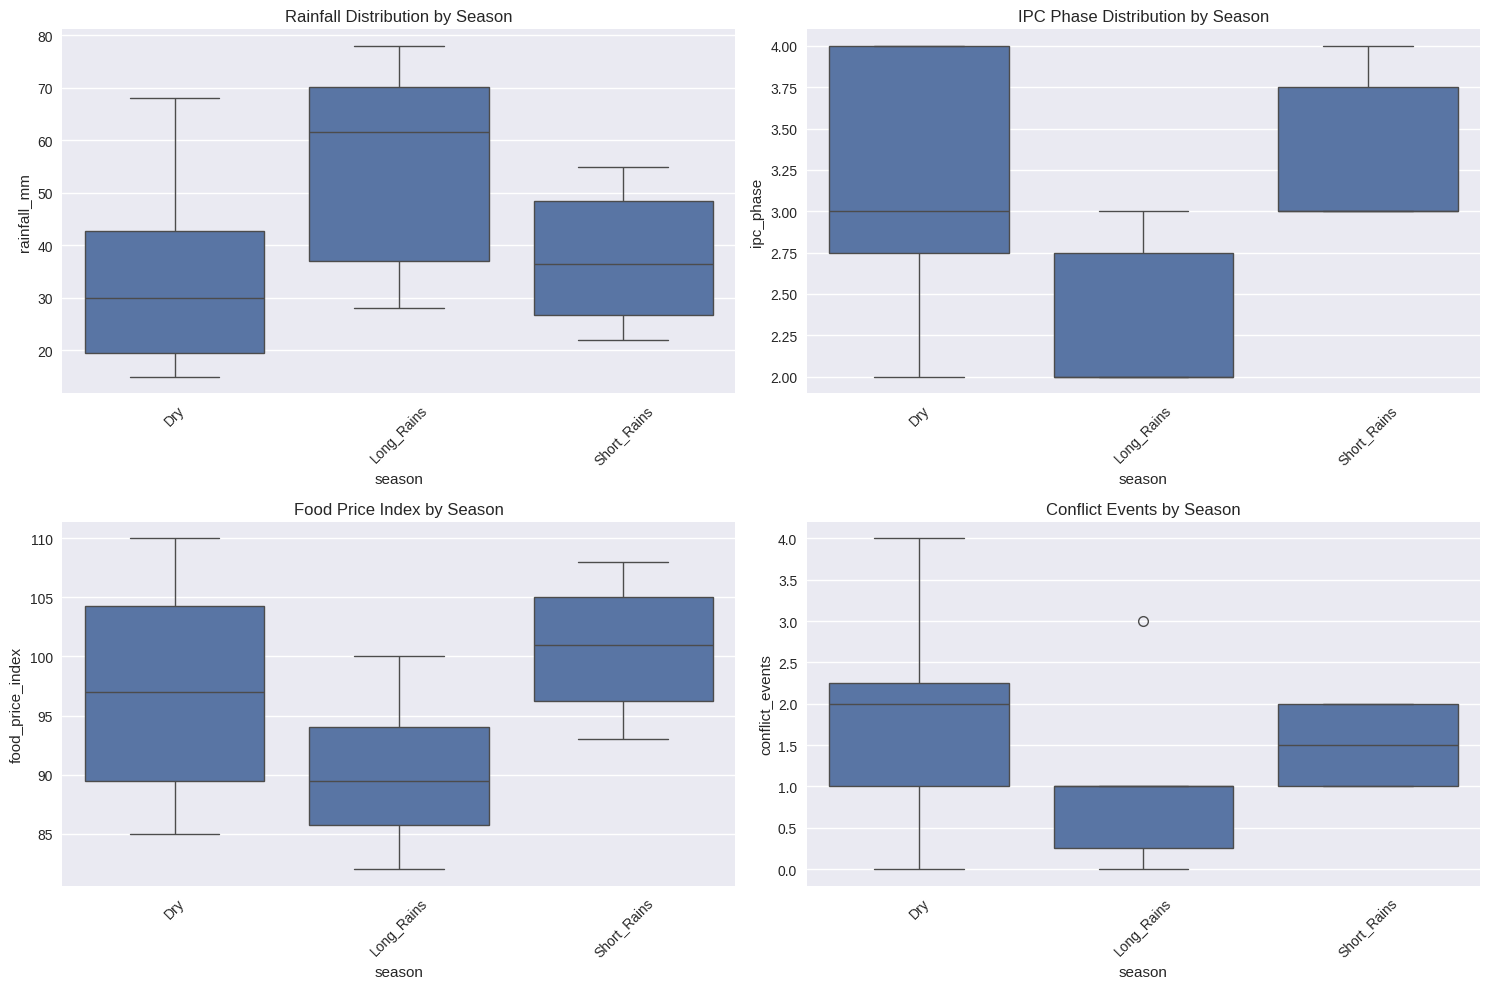

In [50]:
# Seasonal analysis
seasonal_analysis = df.groupby(['season', 'month']).agg({
    'rainfall_mm': 'mean',
    'food_price_index': 'mean',
    'ipc_phase': 'mean',
    'conflict_events': 'sum'
}).round(2)

print("🌦️ SEASONAL PATTERNS")
print("=" * 50)
print(seasonal_analysis)

# Create seasonal visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rainfall by season
sns.boxplot(data=df, x='season', y='rainfall_mm', ax=axes[0,0])
axes[0,0].set_title('Rainfall Distribution by Season')
axes[0,0].tick_params(axis='x', rotation=45)

# IPC phase by season
sns.boxplot(data=df, x='season', y='ipc_phase', ax=axes[0,1])
axes[0,1].set_title('IPC Phase Distribution by Season')
axes[0,1].tick_params(axis='x', rotation=45)

# Food prices by season
sns.boxplot(data=df, x='season', y='food_price_index', ax=axes[1,0])
axes[1,0].set_title('Food Price Index by Season')
axes[1,0].tick_params(axis='x', rotation=45)

# Conflict events by season
sns.boxplot(data=df, x='season', y='conflict_events', ax=axes[1,1])
axes[1,1].set_title('Conflict Events by Season')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [51]:
# Prepare data for modeling
# Remove rows with NaN values (due to lag features)
model_df = df.dropna().copy()

# Define features for prediction
feature_columns = [
    'rainfall_mm', 'rainfall_anomaly', 'temperature_avg', 'food_price_index',
    'conflict_events', 'ndvi_anomaly', 'market_access', 'drought_index',
    'rainfall_lag1', 'food_price_lag1', 'conflict_lag1',
    'rainfall_ma3', 'food_price_ma3', 'month', 'quarter'
]

X = model_df[feature_columns]
y_classification = model_df['ipc_phase']
y_regression = model_df['combined_risk_score']

# Split data for training and testing
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("🤖 MODEL TRAINING")
print("=" * 50)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Features used: {len(feature_columns)}")

# Train Classification Model (IPC Phase Prediction)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_classifier.fit(X_train, y_class_train)

# Train Regression Model (Risk Score Prediction)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_regressor.fit(X_train, y_reg_train)

print("✅ Models trained successfully!")


🤖 MODEL TRAINING
Training set size: 16 samples
Test set size: 5 samples
Features used: 15
✅ Models trained successfully!


🎯 CLASSIFICATION MODEL PERFORMANCE
Accuracy: 0.800

Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2

    accuracy                           0.80         5
   macro avg       0.56      0.67      0.60         5
weighted avg       0.67      0.80      0.72         5



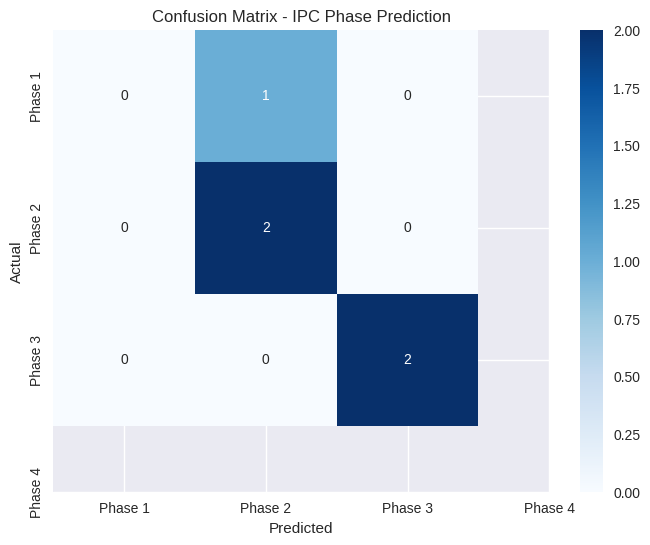


📊 REGRESSION MODEL PERFORMANCE
R² Score: -0.583


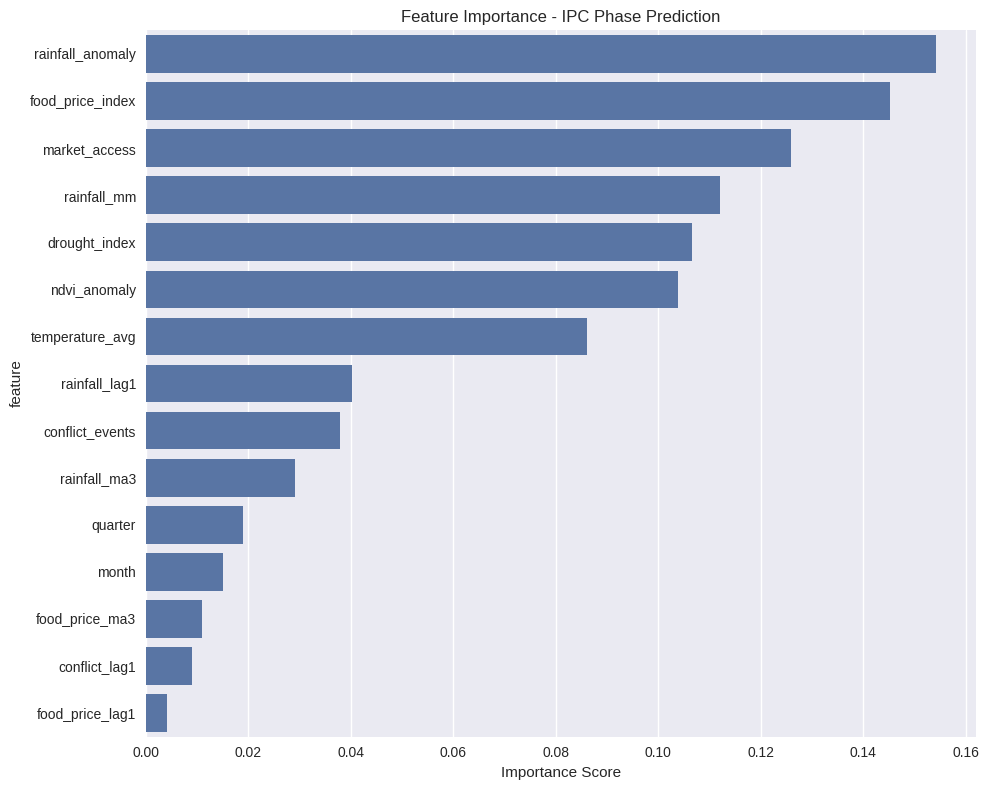


🔍 TOP 10 MOST IMPORTANT FEATURES
rainfall_anomaly     0.154
food_price_index     0.145
market_access        0.126
rainfall_mm          0.112
drought_index        0.107
ndvi_anomaly         0.104
temperature_avg      0.086
rainfall_lag1        0.040
conflict_events      0.038
rainfall_ma3         0.029


In [52]:
# Classification Model Evaluation
y_pred_class = rf_classifier.predict(X_test)
class_accuracy = accuracy_score(y_class_test, y_pred_class)

print("🎯 CLASSIFICATION MODEL PERFORMANCE")
print("=" * 50)
print(f"Accuracy: {class_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_class_test, y_pred_class))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_class_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'],
            yticklabels=['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'])
plt.title('Confusion Matrix - IPC Phase Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Regression Model Evaluation
y_pred_reg = rf_regressor.predict(X_test)
reg_r2 = rf_regressor.score(X_test, y_reg_test)

print(f"\n📊 REGRESSION MODEL PERFORMANCE")
print("=" * 50)
print(f"R² Score: {reg_r2:.3f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - IPC Phase Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\n🔍 TOP 10 MOST IMPORTANT FEATURES")
print("=" * 50)
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:<20} {row['importance']:.3f}")


In [53]:
def predict_food_security(rainfall, food_price, conflicts, temperature=29, 
                         ndvi_anomaly=-0.3, market_access=60, month=7):
    """
    Predict food security status based on input parameters
    
    Parameters:
    - rainfall: Monthly rainfall in mm
    - food_price: Food price index
    - conflicts: Number of conflict events
    - temperature: Average temperature (default: 29°C)
    - ndvi_anomaly: Vegetation health anomaly (default: -0.3)
    - market_access: Market accessibility score (default: 60)
    - month: Month of year (default: 7 for July)
    
    Returns:
    - Dictionary with predictions and risk assessment
    """
    
    # Calculate derived features
    rainfall_anomaly = ((rainfall - 45) / 45) * 100  # Assuming 45mm as average
    drought_index = -1.5 if rainfall < 30 else (-0.5 if rainfall < 50 else 0.2)
    quarter = (month - 1) // 3 + 1
    
    # Create input array
    input_features = np.array([[
        rainfall, rainfall_anomaly, temperature, food_price, conflicts,
        ndvi_anomaly, market_access, drought_index,
        rainfall, food_price, conflicts,  # lag features (simplified)
        rainfall, food_price,  # moving averages (simplified)
        month, quarter
    ]])
    
    # Scale features
    input_scaled = scaler.transform(input_features)
    
    # Make predictions
    ipc_pred = rf_classifier.predict(input_features)[0]
    ipc_proba = rf_classifier.predict_proba(input_features)[0]
    risk_score = rf_regressor.predict(input_features)[0]
    
    # Risk assessment
    if ipc_pred >= 4:
        risk_level = "EMERGENCY"
        color = "🔴"
    elif ipc_pred == 3:
        risk_level = "CRISIS"
        color = "🟠"
    elif ipc_pred == 2:
        risk_level = "STRESSED"
        color = "🟡"
    else:
        risk_level = "MINIMAL"
        color = "🟢"
    
    return {
        'ipc_phase': int(ipc_pred),
        'risk_level': risk_level,
        'risk_score': round(risk_score, 1),
        'confidence': round(max(ipc_proba) * 100, 1),
        'color': color,
        'phase_probabilities': {f'Phase {i+1}': round(prob*100, 1) 
                              for i, prob in enumerate(ipc_proba)}
    }

# Test the prediction function
print("🔮 TESTING PREDICTION FUNCTION")
print("=" * 50)

# Test scenarios
scenarios = [
    {"name": "Current Conditions (July 2024)", "rainfall": 20, "food_price": 104, "conflicts": 4},
    {"name": "Drought Scenario", "rainfall": 10, "food_price": 115, "conflicts": 2},
    {"name": "Good Conditions", "rainfall": 70, "food_price": 80, "conflicts": 0},
    {"name": "Conflict Scenario", "rainfall": 45, "food_price": 95, "conflicts": 6}
]

for scenario in scenarios:
    result = predict_food_security(
        rainfall=scenario["rainfall"],
        food_price=scenario["food_price"],
        conflicts=scenario["conflicts"]
    )
    
    print(f"\n{scenario['name']}:")
    print(f"  {result['color']} IPC Phase: {result['ipc_phase']} ({result['risk_level']})")
    print(f"  Risk Score: {result['risk_score']}/100")
    print(f"  Confidence: {result['confidence']}%")

🔮 TESTING PREDICTION FUNCTION

Current Conditions (July 2024):
  🟠 IPC Phase: 3 (CRISIS)
  Risk Score: 49.5/100
  Confidence: 51.0%

Drought Scenario:
  🟠 IPC Phase: 3 (CRISIS)
  Risk Score: 51.3/100
  Confidence: 53.0%

Good Conditions:
  🟡 IPC Phase: 2 (STRESSED)
  Risk Score: 30.3/100
  Confidence: 74.0%

Conflict Scenario:
  🟠 IPC Phase: 3 (CRISIS)
  Risk Score: 15.1/100
  Confidence: 91.0%


In [54]:
def create_interactive_dashboard():
    """
    Create an interactive dashboard for the food security warning system
    """
    
    # Latest data point
    latest = df.iloc[-1]
    
    # Create dashboard layout
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('IPC Phase Timeline', 'Risk Score Prediction',
                       'Rainfall vs Food Prices', 'Conflict Impact',
                       'Feature Importance', 'Monthly Predictions'),
        specs=[[{"colspan": 2}, None],
               [{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]],
        vertical_spacing=0.12
    )
    
    # 1. IPC Phase Timeline
    fig.add_trace(
        go.Scatter(x=df['date'], y=df['ipc_phase'], mode='lines+markers',
                  name='Actual IPC Phase', line=dict(color='red', width=3),
                  marker=dict(size=8)),
        row=1, col=1
    )
    
    # Add IPC phase bands
    fig.add_hrect(y0=1, y1=2, fillcolor="green", opacity=0.1, row=1, col=1)
    fig.add_hrect(y0=2, y1=3, fillcolor="yellow", opacity=0.1, row=1, col=1)
    fig.add_hrect(y0=3, y1=4, fillcolor="orange", opacity=0.1, row=1, col=1)
    fig.add_hrect(y0=4, y1=5, fillcolor="red", opacity=0.1, row=1, col=1)
    
    # 2. Rainfall vs Food Prices (scatter)
    fig.add_trace(
        go.Scatter(x=df['rainfall_mm'], y=df['food_price_index'],
                  mode='markers', name='Data Points',
                  marker=dict(size=8, color=df['ipc_phase'], 
                            colorscale='RdYlGn_r', showscale=True,
                            colorbar=dict(title="IPC Phase"))),
        row=2, col=1
    )
    
    # 3. Conflict Events
    fig.add_trace(
        go.Bar(x=df['date'], y=df['conflict_events'], name='Conflict Events',
              marker_color='darkred', opacity=0.7),
        row=2, col=2
    )
    
    # 4. Feature Importance
    fig.add_trace(
        go.Bar(x=feature_importance['importance'][:8], 
               y=feature_importance['feature'][:8],
               orientation='h', name='Feature Importance',
               marker_color='steelblue'),
        row=3, col=1
    )
    
    # 5. Predictions for next 3 months
    future_months = ['Aug 2024', 'Sep 2024', 'Oct 2024']
    predictions = []
    
    for i, month in enumerate(future_months):
        # Simulate future predictions
        pred_rainfall = max(15, latest['rainfall_mm'] + np.random.normal(0, 10))
        pred_price = latest['food_price_index'] + np.random.normal(0, 5)
        pred_conflicts = max(0, int(latest['conflict_events'] + np.random.normal(0, 1)))
        
        pred_result = predict_food_security(pred_rainfall, pred_price, pred_conflicts)
        predictions.append(pred_result['ipc_phase'])
    
    fig.add_trace(
        go.Bar(x=future_months, y=predictions, name='Predicted IPC Phase',
              marker_color=['red' if p >= 4 else 'orange' if p == 3 else 'yellow' if p == 2 else 'green' 
                           for p in predictions]),
        row=3, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="🇰🇪 Kenya Food Security Warning System - Interactive Dashboard",
        title_x=0.5,
        height=900,
        showlegend=True,
        template="plotly_white"
    )
    
    # Add annotations for current status
    fig.add_annotation(
        text=f"Current Status: IPC Phase {int(latest['ipc_phase'])} - {latest['county']}",
        xref="paper", yref="paper",
        x=0.5, y=0.95, showarrow=False,
        font=dict(size=14, color="black"),
        bgcolor="lightblue", bordercolor="blue", borderwidth=1
    )
    
    return fig

# Create and display the dashboard
dashboard = create_interactive_dashboard()
dashboard.show()

print("📊 Interactive Dashboard Created!")
print("=" * 50)
print("✅ Dashboard includes:")
print("   • IPC Phase Timeline with risk bands")
print("   • Rainfall vs Food Price relationship")

📊 Interactive Dashboard Created!
✅ Dashboard includes:
   • IPC Phase Timeline with risk bands
   • Rainfall vs Food Price relationship


In [55]:
# Save the trained models and the scaler for future use
joblib.dump(rf_classifier, 'rf_classifier_food_security.pkl')
joblib.dump(rf_regressor, 'rf_regressor_food_security.pkl')
joblib.dump(scaler, 'scaler_food_security.pkl')

print("💾 Models and scaler saved successfully!")
print("   • 'rf_classifier_food_security.pkl'")
print("   • 'rf_regressor_food_security.pkl'")
print("   • 'scaler_food_security.pkl'")

💾 Models and scaler saved successfully!
   • 'rf_classifier_food_security.pkl'
   • 'rf_regressor_food_security.pkl'
   • 'scaler_food_security.pkl'


In [56]:

# Load the saved models and scaler
loaded_classifier = joblib.load('rf_classifier_food_security.pkl')
loaded_regressor = joblib.load('rf_regressor_food_security.pkl')
loaded_scaler = joblib.load('scaler_food_security.pkl')

print("🔄 Models and scaler loaded successfully for new predictions!")

def predict_food_security_loaded(rainfall, food_price, conflicts, temperature=29, 
                                 ndvi_anomaly=-0.3, market_access=60, month=7):
    """
    Predict food security status based on input parameters using loaded models.
    
    Parameters:
    - rainfall: Monthly rainfall in mm
    - food_price: Food price index
    - conflicts: Number of conflict events
    - temperature: Average temperature (default: 29°C)
    - ndvi_anomaly: Vegetation health anomaly (default: -0.3)
    - market_access: Market accessibility score (default: 60)
    - month: Month of year (default: 7 for July)
    
    Returns:
    - Dictionary with predictions and risk assessment
    """
    
    # Calculate derived features (must be consistent with training data)
    rainfall_anomaly = ((rainfall - 45) / 45) * 100  # Assuming 45mm as average used in feature engineering
    drought_index = -1.5 if rainfall < 30 else (-0.5 if rainfall < 50 else 0.2)
    quarter = (month - 1) // 3 + 1
    
    # Create input array
    input_features = np.array([[
        rainfall, rainfall_anomaly, temperature, food_price, conflicts,
        ndvi_anomaly, market_access, drought_index,
        rainfall, food_price, conflicts,  # lag features (simplified for new prediction)
        rainfall, food_price,  # moving averages (simplified for new prediction)
        month, quarter
    ]])
    
    # Scale features using the loaded scaler
    input_scaled = loaded_scaler.transform(input_features)
    
    # Make predictions
    ipc_pred = loaded_classifier.predict(input_scaled)[0]
    ipc_proba = loaded_classifier.predict_proba(input_scaled)[0]
    risk_score = loaded_regressor.predict(input_scaled)[0]
    
    # Risk assessment
    if ipc_pred >= 4:
        risk_level = "EMERGENCY"
        color = "🔴"
    elif ipc_pred == 3:
        risk_level = "CRISIS"
        color = "🟠"
    elif ipc_pred == 2:
        risk_level = "STRESSED"
        color = "🟡"
    else:
        risk_level = "MINIMAL"
        color = "🟢"
    
    return {
        'ipc_phase': int(ipc_pred),
        'risk_level': risk_level,
        'risk_score': round(risk_score, 1),
        'confidence': round(max(ipc_proba) * 100, 1),
        'color': color,
        'phase_probabilities': {f'Phase {i+1}': round(prob*100, 1) 
                                for i, prob in enumerate(ipc_proba)}
    }

print("\n🚀 Making a new prediction using loaded models:")
# Example: Predict for a future scenario with increased food prices and conflicts
new_rainfall = 30 # mm
new_food_price = 110 # index
new_conflicts = 5 # events
new_month = 8 # August

new_prediction_result = predict_food_security_loaded(
    rainfall=new_rainfall,
    food_price=new_food_price,
    conflicts=new_conflicts,
    month=new_month
)

print(f"Scenario: Rainfall={new_rainfall}mm, Food Price={new_food_price}, Conflicts={new_conflicts}, Month={new_month}")
print(f"  {new_prediction_result['color']} Predicted IPC Phase: {new_prediction_result['ipc_phase']} ({new_prediction_result['risk_level']})")
print(f"  Predicted Risk Score: {new_prediction_result['risk_score']}/100")
print(f"  Confidence: {new_prediction_result['confidence']}%")
print(f"  Phase Probabilities: {new_prediction_result['phase_probabilities']}")


🔄 Models and scaler loaded successfully for new predictions!

🚀 Making a new prediction using loaded models:
Scenario: Rainfall=30mm, Food Price=110, Conflicts=5, Month=8
  🟠 Predicted IPC Phase: 3 (CRISIS)
  Predicted Risk Score: 36.6/100
  Confidence: 42.0%
  Phase Probabilities: {'Phase 1': np.float64(36.0), 'Phase 2': np.float64(42.0), 'Phase 3': np.float64(22.0)}


In [57]:

print("\n⏩ NEXT STEPS AND RECOMMENDATIONS")
print("=" * 50)

print("1. Data Collection and Integration:")
print("   • Continuously update the dataset with the latest monthly data for rainfall, food prices, conflict, NDVI, etc.")
print("   • Explore integrating more granular data sources (e.g., specific crop yields, livestock health, local market data).")
print("   • Consider incorporating climate change projections and long-term economic forecasts.")

print("\n2. Model Refinement and Monitoring:")
print("   • Regularly re-train models with new data to capture evolving patterns and maintain accuracy.")
print("   • Implement A/B testing for different model architectures (e.g., Gradient Boosting, LSTM for time series).")
print("   • Establish a robust model monitoring system to detect performance degradation and data drift.")
print("   • Optimize hyperparameters using techniques like GridSearchCV or RandomizedSearchCV for better performance.")

print("\n3. User Interface and Alert System:")
print("   • Develop a dedicated web application for the dashboard to make it accessible to stakeholders.")
print("   • Implement an automated alert system (email, SMS) for high-risk predictions or IPC phase deteriorations.")
print("   • Design user-friendly input forms for the prediction function to allow manual scenario testing.")

print("\n4. Spatial Analysis:")
print("   • Expand the system to cover more counties, accounting for regional variations in food security drivers.")
print("   • Develop interactive maps showing IPC phase predictions and risk scores at the county level.")
print("   • Integrate GIS data for more localized insights (e.g., road networks, water sources).")

print("\n5. Policy and Intervention Support:")
print("   • Work with policymakers to define clear thresholds for early action based on prediction outcomes.")
print("   • Conduct sensitivity analysis to understand how changes in input variables impact food security outcomes, informing targeted interventions.")
print("   • Develop counterfactual scenarios to assess the potential impact of different intervention strategies (e.g., food aid, cash transfers).")

print("\n6. Collaboration and Validation:")
print("   • Collaborate with local food security experts, NGOs, and government agencies for ground-truthing and validation of predictions.")
print("   • Share insights and findings with the broader humanitarian and development community.")

print("\n💡 This system provides a strong foundation for proactive food security management in Kenya. Continuous improvement and stakeholder engagement will be key to its long-term success.")




⏩ NEXT STEPS AND RECOMMENDATIONS
1. Data Collection and Integration:
   • Continuously update the dataset with the latest monthly data for rainfall, food prices, conflict, NDVI, etc.
   • Explore integrating more granular data sources (e.g., specific crop yields, livestock health, local market data).
   • Consider incorporating climate change projections and long-term economic forecasts.

2. Model Refinement and Monitoring:
   • Regularly re-train models with new data to capture evolving patterns and maintain accuracy.
   • Implement A/B testing for different model architectures (e.g., Gradient Boosting, LSTM for time series).
   • Establish a robust model monitoring system to detect performance degradation and data drift.
   • Optimize hyperparameters using techniques like GridSearchCV or RandomizedSearchCV for better performance.

3. User Interface and Alert System:
   • Develop a dedicated web application for the dashboard to make it accessible to stakeholders.
   • Implement an au